In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x1 = torch.rand(50)
train_x2 = torch.rand(50)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2

In [3]:
train_x1

tensor([0.4840, 0.2777, 0.6240, 0.6369, 0.1527, 0.8669, 0.4353, 0.9958, 0.8511,
        0.5523, 0.3157, 0.5938, 0.7476, 0.9362, 0.3908, 0.4365, 0.2699, 0.1178,
        0.1127, 0.8179, 0.9434, 0.0874, 0.6172, 0.2750, 0.7082, 0.4580, 0.3342,
        0.0886, 0.4596, 0.8747, 0.8801, 0.4561, 0.4933, 0.4655, 0.3084, 0.7851,
        0.6973, 0.9062, 0.8116, 0.9196, 0.1886, 0.5644, 0.8145, 0.1416, 0.9422,
        0.3953, 0.1751, 0.7839, 0.3451, 0.7419])

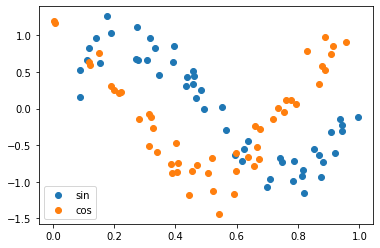

In [14]:
plt.scatter(train_x1, train_y1, label='sin')
plt.scatter(train_x2, train_y2, label='cos')
plt.legend();

### Hadamard multitask model

In [15]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_i_task1 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x2.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x1, train_x2])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y1, train_y2])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [24]:
full_train_x.shape, full_train_y.shape

(torch.Size([100]), torch.Size([100]))

In [26]:
full_train_i.shape

torch.Size([100, 1])

### Training the model

In [16]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.951
Iter 2/50 - Loss: 0.910
Iter 3/50 - Loss: 0.871
Iter 4/50 - Loss: 0.833
Iter 5/50 - Loss: 0.797
Iter 6/50 - Loss: 0.761
Iter 7/50 - Loss: 0.725
Iter 8/50 - Loss: 0.689
Iter 9/50 - Loss: 0.652
Iter 10/50 - Loss: 0.615
Iter 11/50 - Loss: 0.579
Iter 12/50 - Loss: 0.543
Iter 13/50 - Loss: 0.508
Iter 14/50 - Loss: 0.474
Iter 15/50 - Loss: 0.440
Iter 16/50 - Loss: 0.405
Iter 17/50 - Loss: 0.370
Iter 18/50 - Loss: 0.335
Iter 19/50 - Loss: 0.299
Iter 20/50 - Loss: 0.264
Iter 21/50 - Loss: 0.231
Iter 22/50 - Loss: 0.199
Iter 23/50 - Loss: 0.170
Iter 24/50 - Loss: 0.143
Iter 25/50 - Loss: 0.118
Iter 26/50 - Loss: 0.094
Iter 27/50 - Loss: 0.073
Iter 28/50 - Loss: 0.053
Iter 29/50 - Loss: 0.036
Iter 30/50 - Loss: 0.022
Iter 31/50 - Loss: 0.011
Iter 32/50 - Loss: 0.003
Iter 33/50 - Loss: -0.003
Iter 34/50 - Loss: -0.006
Iter 35/50 - Loss: -0.008
Iter 36/50 - Loss: -0.007
Iter 37/50 - Loss: -0.006
Iter 38/50 - Loss: -0.003
Iter 39/50 - Loss: -0.001
Iter 40/50 - Loss: 0.002
It

/home/danh/miniconda3/envs/mogp/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


### Make prediction

In [21]:
# Set into eval mode
model.eval()
likelihood.eval()

# Test points every 0.02 in [0,1]
test_x = torch.linspace(0, 1, 51)
test_i_task1 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task2 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=1)

In [22]:
test_x

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800, 0.2000, 0.2200, 0.2400, 0.2600, 0.2800, 0.3000, 0.3200, 0.3400,
        0.3600, 0.3800, 0.4000, 0.4200, 0.4400, 0.4600, 0.4800, 0.5000, 0.5200,
        0.5400, 0.5600, 0.5800, 0.6000, 0.6200, 0.6400, 0.6600, 0.6800, 0.7000,
        0.7200, 0.7400, 0.7600, 0.7800, 0.8000, 0.8200, 0.8400, 0.8600, 0.8800,
        0.9000, 0.9200, 0.9400, 0.9600, 0.9800, 1.0000])

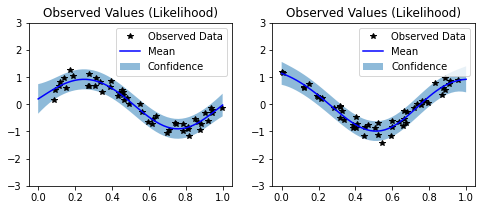

In [18]:
# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1 = likelihood(model(test_x, test_i_task1))
    observed_pred_y2 = likelihood(model(test_x, test_i_task2))

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
    
# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot both tasks
ax_plot(y1_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, train_x2, observed_pred_y2, 'Observed Values (Likelihood)')